In [171]:
import pandas as pd
import cv2
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report

%matplotlib inline
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import ibmseti
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
import zipfile

from obspy.core import read
from obspy.signal.trigger import classic_sta_lta
from astropy.convolution import convolve, Box1DKernel
from scipy import ndimage

In [134]:
# Find the data in the zip file
mydatafolder = '../data'
zz = zipfile.ZipFile(os.path.join(mydatafolder, 'basic4.zip'))
basic4list = zz.namelist() #list of all the image files 
firstfile = basic4list[1400] #for testing 

label_csv = pd.read_csv('../data/public_list_basic_v2_26may_2017.csv') #labels for basic4 data 
label_csv.index = label_csv.UUID #make ID the index

In [126]:
# processors 
def spectrogram_raw(in_file):
    '''
    raw np array of spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2
    
    return spectrogram


def seismogram(in_file):    
    '''
    Sanjoy's Seismogram image processing function 
    Create binary image of highly denoised spectrogram 
    '''
    
    # Read data into ibmseti object
    aca = ibmseti.compamp.SimCompamp(zz.open(in_file).read())

    # Get the raw complex data
    complex_data = aca.complex_data()
    complex_data = complex_data.reshape(32, 6144)
    cpfft = np.fft.fftshift( np.fft.fft(complex_data), 1)
    spectrogram = np.abs(cpfft)**2

    # Create a new empty spectrogram to contain the smooth spedtrogram values
    smoothedspectro=np.zeros(np.shape(spectrogram))

    # Apply seismogram filtering to data
    for i in range(np.shape(spectrogram)[0]):
        background = convolve(spectrogram[i], Box1DKernel(100))
        smoothedspectro[i]=spectrogram[i] - background
        df = 20
        cft = classic_sta_lta(smoothedspectro[i], int(5 * df), int(10 * df))
        indices_ut = np.where(cft>1.7)
        indices_ut = list(indices_ut[0])
        indices_lt = np.where(cft<0.2)
        indices_lt  = list(indices_lt[0])
        indices = indices_ut + indices_lt
        indices_zero = range(0,6144)
        indices_zero = list(set(indices_zero) - set(indices))
        smoothedspectro[i][indices_zero] = 0
        smoothedspectro[i][indices_ut] = 1
        smoothedspectro[i][indices_lt] = 1
        smoothedspectro[i][:500] = 0

    # Binarize the image
    ndimage.binary_erosion(np.asarray(smoothedspectro), structure=np.ones((100,100))).astype(np.int)
    
    return smoothedspectro

# #Plot siesmo spectrogram
# fig, ax = plt.subplots(figsize=(8, 4))
# cmap = plt.cm.get_cmap("binary")
# ax.imshow(spectrogram, cmap=cmap,aspect = 0.5*float(spectrogram.shape[1]) / spectrogram.shape[0])
# ax.set_axis_off()

In [127]:
#linear (r^2) classifier for narrowband/DRD 
def narrow_linear_fit(image):
    
    '''
    arugments:  the image file name 
    
    this function applies image processing for smoothing/closing
    it then skeletonizes the image to a line width of one
    these pixel locations are taken and fit to a linear model 
    r^2 is taken to distinguish between narrowband (linear) and narrowbandrd (curved)
    
    returns: linear model object, dependent values for line, independent values for line, spectrogram 
    '''
    
    # IMAGE PROCESSING #
    spectrogram = seismogram(image)
    spectrogram = np.uint8(spectrogram) #prep for openCV 
    kernel = np.ones((11,11),np.uint8) #kernel size for morpho closing 
    spectrogram = cv2.morphologyEx(spectrogram, cv2.MORPH_CLOSE, kernel) #close holes 
    spectrogram = cv2.GaussianBlur(spectrogram, (11,11), 0) #close gaps
    spectrogram[spectrogram > 0] = 255 #make binary
    
    #skeletonize the band, put line loc into curve list 
    def skeletonize(row):
        return np.median(np.array(np.nonzero(row > 0))) 
    curve = []
    curve.append(np.apply_along_axis(skeletonize, 1, spectrogram))
    curve =  np.array(curve).flatten() #convert to numpy for speed 
    curve = curve[~np.isnan(curve)] # get rid of NAN values (where image is blank)
    curve_std = np.std(curve) #standard deviation of curve values
    
    #scale data between 0-~32 (height of raw image, minus the dropped NANs)
    scaler = MinMaxScaler()
    curve = scaler.fit_transform(curve.reshape(-1, 1))
    X = np.linspace((curve.shape[0]-1), 0, curve.shape[0]).flatten()
    curve = curve*X.shape[0] 
    
    #constrain  edges (seemed to cause some issues)
    curve = curve[2:-2] 
    X = X[2:-2]
    
    #fit a linear regression to the skeletonized line
    X = sm.add_constant(X)
    linear_fit = sm.OLS(curve, X).fit() 
    slope, intercept = linear_fit.params

    return linear_fit, curve, X, slope, intercept, curve_std, spectrogram 

In [81]:
#split data into features (images) and classes (labels)
full_df = pd.read_csv('flattend_square.csv')
labels_true = full_df.iloc[:, 0]
names = full_df.iloc[:, 1]
images = full_df.iloc[:, 2:]
images[images>0]=1  #convert back to binary (compression changed that)

In [162]:
#machine learning! 

#get subsets of data to test around with 
labels = labels_true #make copy of originals 

#change labels for linreg classifier. We want narrowband and DRD to appear 
#as the same class, so that the 1st pass classifier has an easier time distinguishing 
def change_label(x):
    if x=='narrowbanddrd':
        return 'narrowband'
    else:
        return x
labels= labels.apply(change_label)

#train test split
trainX = images[:3000]
testX = images[3001:]
trainY = labels[:3000]
testY = labels[3001:]
trainY_true = labels_true[:3000]
testY_true = labels_true[3001:]

In [173]:
#apply SVM (pretuned via grid search)
clf = svm.SVC(C = 10, gamma=0.01)
clf.fit(trainX, trainY)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [174]:
#apply predictions on test data 
#concat w/ true labels (untouched narrowbandDRD)

SVM_pred = pd.DataFrame(clf.predict(testX), index=testY.index)
frames = [testY_true, testY, SVM_pred]
all_y = pd.concat(frames, axis=1)
all_y.columns =['testY_true', 'testY_SVM', 'prediction']

In [175]:
#whats our accuracy of the first pass classifier?
#when the narrowband and narrowbandDRD were separate, this was 68%
#this is just to validate the accuracy of the 3 classes, where N and NDRD are combined 
total = all_y.shape[0]
correct = 0
for i in all_y.index: 
    if all_y.ix[i]['testY_SVM'] == all_y.ix[i]['prediction']:
        correct+= 1
correct/float(total)

0.938938938938939

In [177]:
#TO DO - CHANGE THIS TO A APPLY FUNCITION FOR SPEED  

#apply linear regression/r^2 classifier 
#change the predictions 

r2_threshold = 0.996

for i in all_y.index:
    if all_y.ix[i]['prediction'] == 'narrowband': #if SVM returns narrowband, use linear classifier 
        ID = full_df.ix[i][1]+'.dat'
        model, line, x, m, b, std, spectrogram  = narrow_linear_fit(ID) #apply linear function 
#         print model.rsquared_adj, std
        if  model.rsquared_adj > r2_threshold: 
            prediction = 'narrowband'
        else:
            if std<5:     #add standard deviation conditional
                prediction = 'narrowband'
            else:
                prediction = 'narrowbanddrd'
        all_y.ix[i]['prediction'] = prediction

In [168]:
#get the new accuracy score 
#were looking for an improvement on 68%

total = all_y.shape[0]
correct = 0
for i in all_y.index: 
    if all_y.ix[i]['testY_true'] == all_y.ix[i]['prediction']:
        correct+= 1
correct/float(total)

0.8958958958958959

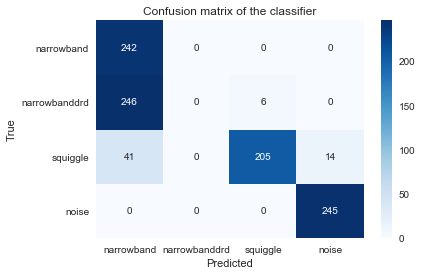

In [176]:
#lets look at a confusion matrix to see where our errors are 

labels = ['narrowband', 'narrowbanddrd', 'squiggle', 'noise']
cm = confusion_matrix(all_y['testY_true'], all_y['prediction'], labels=labels) 
cm = pd.DataFrame(data=cm, columns=labels, index=labels)

fig = plt.figure()
sb.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()